In [44]:
LOAD_MODELS = False
RUN_NUM = 1

In [45]:
!cp -r ../input/carrefour/* /kaggle/working/

In [46]:
!pip install -r requirements.txt

In [47]:
!pip install lightfm tqdm optuna ipykernel matplotlib implicit

In [48]:
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disable it with 

# Imports

In [49]:
import time
import optuna
import numpy as np
import pandas as pd
import scipy.sparse as sps
from scipy.sparse import vstack, csr_matrix
from scipy.stats import loguniform
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from tqdm import tqdm
import os

seed = 69
np.random.seed(seed)

In [50]:
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.BaseMatrixFactorizationRecommender import BaseMatrixFactorizationRecommender
from Recommenders.NonPersonalizedRecommender import TopPop

#---- CF
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

#---- Matrix Factorization
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

#---- CF w/ ML
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender, MultiThreadSLIM_SLIMElasticNetRecommender
from implicit.als import AlternatingLeastSquares

#---- Gradient Boosting
import xgboost as xgb
from xgboost import XGBRanker

#---- Others
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.Recommender_utils import check_matrix
from Recommenders.DataIO import DataIO

# Run Versioning (For Model + Split saving)

In [51]:
BASE_DIR = "Runs/"

In [52]:
def get_next_folder_number(base_dir):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    existing_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    existing_numbers = [int(f[1:]) for f in existing_folders if f.startswith('#') and f[1:].isdigit()]

    next_number = 1
    if existing_numbers:
        next_number = max(existing_numbers) + 1

    return f"#{next_number}"

def create_versioned_folder(base_dir):
    folder_name = get_next_folder_number(base_dir)
    new_folder_path = os.path.join(base_dir, folder_name)
    os.makedirs(new_folder_path)
    return new_folder_path

In [53]:
run_folder = create_versioned_folder(BASE_DIR)
print(f"New folder created: {run_folder}")

New folder created: Runs/#2


# Data Import and Preprocessing

In [54]:
# Import training data
URM_path = "../input/data-book/data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path,
                                header=0,
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["user_id", "item_id", "interaction"]

In [55]:
# Import target users
target_path = "../input/data-book/data_target_users_test.csv"
target_dataframe= pd.read_csv(filepath_or_buffer=target_path,
                                header=0,
                                dtype={0:int},
                                engine='python')
target_dataframe.columns = ["user_id"]
target_dataframe

,user_id
0,1
1,2
2,3
3,4
4,5
...,...
10877,13020
10878,13021
10879,13022
10880,13023


In [56]:
def preprocess_data(ratings: pd.DataFrame):
    unique_users = ratings.user_id.unique()
    unique_items = ratings.item_id.unique()

    num_users, min_user_id, max_user_id = unique_users.size, unique_users.min(), unique_users.max()
    num_items, min_item_id, max_item_id = unique_items.size, unique_items.min(), unique_items.max()

    print(num_users, min_user_id, max_user_id)
    print(num_items, min_item_id, max_item_id)

    mapping_user_id = pd.DataFrame({"mapped_user_id": np.arange(num_users), "user_id": unique_users})
    mapping_item_id = pd.DataFrame({"mapped_item_id": np.arange(num_items), "item_id": unique_items})

    ratings = pd.merge(left=ratings,
                       right=mapping_user_id,
                       how="inner",
                       on="user_id")

    ratings = pd.merge(left=ratings,
                       right=mapping_item_id,
                       how="inner",
                       on="item_id")

    return ratings

In [57]:
# Call preprocess data function
ratings = preprocess_data(URM_all_dataframe)

12638 1 13024
22222 1 22347


## Conversion to Sparse Matrix

In [58]:
URM = sps.coo_matrix((ratings.interaction.values, (ratings.mapped_user_id.values, ratings.mapped_item_id.values)))

## Data Splits

In [59]:
def split_urm_in_k_folds(URM_all, k):
    from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix
    num_users, num_items = URM_all.shape

    URM_train = sps.coo_matrix(URM_all)

    indices_for_sampling = np.arange(0, URM_all.nnz, dtype=int)
    np.random.shuffle(indices_for_sampling)

    indices_for_sampling = np.array_split(indices_for_sampling, k)
    np.random.shuffle(indices_for_sampling)
    k_URM = []
    
    for i in range(k):
        URM_builder = IncrementalSparseMatrix(n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, auto_create_row_mapper=False)
        URM_builder.add_data_lists(URM_train.row[indices_for_sampling[i]],
                                             URM_train.col[indices_for_sampling[i]],
                                             URM_train.data[indices_for_sampling[i]])

        k_URM.append(sps.csr_matrix(URM_builder.get_SparseMatrix()))

    #verify that the sum of the URM_train_matrices is equal to the original URM
    k_URM_sum = sps.csr_matrix((num_users, num_items))
    for URM_train_matrices_single in k_URM:
        k_URM_sum += URM_train_matrices_single
    
    assert k_URM_sum.nnz == URM_all.nnz, "split_train_in_k_percentage_global_sample: URM_train_matrices_sum doesn't match URM_all"


    return k_URM

In [60]:
#urm_train, urm_test = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
#urm_train, urm_validation = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)

#evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
#evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10])

In [61]:
k = 10
splits = split_urm_in_k_folds(URM, k)

In [62]:
'''urm_train = sum(splits[:7])
urm_val = sum(splits[7:9])
urm_test = splits[9]
evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10])'''
urm_train = sum(splits[:8])
urm_val = sum(splits[8:])

In [63]:
sps.save_npz(f"{run_folder}/URM_train.npz", urm_train)
sps.save_npz(f"{run_folder}/URM_val.npz", urm_val)
#sps.save_npz(f"{run_folder}/URM_test.npz", urm_test)

# Load Data (Pre-split)

In [64]:
run_folder = f"{BASE_DIR}#{RUN_NUM}/" # Runs/#1/

In [65]:
urm_train = sps.load_npz(f"{run_folder}URM_train.npz")
urm_val = sps.load_npz(f"{run_folder}URM_val.npz")
#urm_test = sps.load_npz(f"{run_folder}URM_test.npz")
#evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10])

# Custom Recommenders

## IALS

In [66]:
class FastIALSRecommender(BaseMatrixFactorizationRecommender):
    RECOMMENDER_NAME = "FastIALSRecommender"

    AVAILABLE_CONFIDENCE_SCALING = ["linear", "log"]
    
    def __init__(self, URM_train, verbose=True):
        super().__init__(URM_train, verbose=verbose)
        
    def fit(self,
            factors=20,
            regularization=1e-3,
            iterations=100,
            calculate_training_loss=False,
            num_threads=0,
            confidence_scaling='linear',
            alpha=1.0,
            epsilon=0,
            #---- Do not change
            use_native=True,
            use_cg=True,
            use_gpu=True):
        if confidence_scaling not in self.AVAILABLE_CONFIDENCE_SCALING:
           raise ValueError("Value for 'confidence_scaling' not recognized. Acceptable values are {}, provided was '{}'".format(self.AVAILABLE_CONFIDENCE_SCALING, confidence_scaling))

        self.alpha = alpha
        self.epsilon = epsilon
        self.num_factors = factors
        self.reg = regularization
        
        self.USER_factors = self._init_factors(self.n_users, False)  # don't need values, will compute them
        self.ITEM_factors = self._init_factors(self.n_items)
        
        self.recommender = AlternatingLeastSquares(factors=factors, regularization=regularization,
                                                        use_native=use_native, use_cg=use_cg, use_gpu=use_gpu,
                                                        iterations=iterations,
                                                        calculate_training_loss=calculate_training_loss,
                                                        num_threads=num_threads)
        
        self._build_confidence_matrix(confidence_scaling)
        self.recommender.fit(self.C, show_progress=self.verbose)
        
        self.USER_factors = self.recommender.user_factors.to_numpy()
        self.ITEM_factors = self.recommender.item_factors.to_numpy()
        
    
    def _linear_scaling_confidence(self):

        C = check_matrix(self.URM_train, format="csr", dtype = np.float32)
        C.data = 1.0 + self.alpha*C.data

        return C

    def _log_scaling_confidence(self):

        C = check_matrix(self.URM_train, format="csr", dtype = np.float32)
        C.data = 1.0 + self.alpha * np.log(1.0 + C.data / self.epsilon)

        return C
    
    def _build_confidence_matrix(self, confidence_scaling):

        if confidence_scaling == 'linear':
            self.C = self._linear_scaling_confidence()
        else:
            self.C = self._log_scaling_confidence()

        self.C_csc= check_matrix(self.C.copy(), format="csc", dtype = np.float32)
    
    def _init_factors(self, num_factors, assign_values=True):

        if assign_values:
            return self.num_factors**-0.5*np.random.random_sample((num_factors, self.num_factors))

        else:
            return np.empty((num_factors, self.num_factors))

## LightFM

In [67]:
class LightFMCFRecommender(BaseRecommender):
    """LightFMCFRecommender"""

    RECOMMENDER_NAME = "LightFMCFRecommender"

    def __init__(self, URM_train):
        super(LightFMCFRecommender, self).__init__(URM_train)
    
    
    def fit(self, epochs = 300, user_alpha=1e-6, item_alpha = 1e-6, n_factors = 10, n_threads = 4, max_sampled=3, loss='warp', learning_schedule='adagrad'):
        
        # Let's fit a WARP model
        self.lightFM_model = LightFM(loss=loss,
                                     user_alpha=user_alpha,
                                     item_alpha=item_alpha,
                                     no_components=n_factors,
                                     max_sampled=max_sampled,
                                     learning_schedule=learning_schedule)

        self.lightFM_model = self.lightFM_model.fit(self.URM_train, 
                                       epochs=epochs,
                                       num_threads=n_threads,
                                       verbose=True)


    def _compute_item_score(self, user_id_array, items_to_compute = None):
        
        # Create a single (n_items, ) array with the item score, then copy it for every user
        items_to_compute = np.arange(self.n_items)
        
        item_scores = - np.ones((len(user_id_array), self.n_items)) * np.inf

        for user_index, user_id in enumerate(user_id_array):
            item_scores[user_index] = self.lightFM_model.predict(int(user_id), 
                                                                 items_to_compute)

        return item_scores
    
    def save_model(self, folder_path, file_name = None):

        if file_name is None:
            file_name = self.RECOMMENDER_NAME

        self._print("Saving model in file '{}'".format(folder_path + file_name))

        data_dict_to_save = {
                            "item_embeddings": self.lightFM_model.item_embeddings,
                            "item_embedding_gradients": self.lightFM_model.item_embedding_gradients,
                            "item_embedding_momentum": self.lightFM_model.item_embedding_momentum,
                            "item_biases": self.lightFM_model.item_biases,
                            "item_bias_gradients": self.lightFM_model.item_bias_gradients,
                            "item_bias_momentum": self.lightFM_model.item_bias_momentum,
                            "user_embeddings": self.lightFM_model.user_embeddings,
                            "user_embedding_gradients": self.lightFM_model.user_embedding_gradients,
                            "user_embedding_momentum": self.lightFM_model.user_embedding_momentum,
                            "user_biases": self.lightFM_model.user_biases,
                            "user_bias_gradients": self.lightFM_model.user_bias_gradients,
                            "user_bias_momentum": self.lightFM_model.user_bias_momentum,
                            }


        dataIO = DataIO(folder_path=folder_path)
        dataIO.save_data(file_name=file_name, data_dict_to_save = data_dict_to_save)

        self._print("Saving complete")
        
        
    def load_model(self, folder_path, file_name = None):

        if file_name is None:
            file_name = self.RECOMMENDER_NAME

        self._print("Loading model from file '{}'".format(folder_path + file_name))

        dataIO = DataIO(folder_path=folder_path)
        data_dict = dataIO.load_data(file_name=file_name)

        self.lightFM_model = LightFM()

        for attrib_name in data_dict.keys():
             self.lightFM_model.__setattr__(attrib_name, data_dict[attrib_name])

        self._print("Loading complete")

        
        

# Custom XGRecommender Class

In [68]:
class Recommender():
    def __init__(self, recommender_name, recommender_class, params_dict):
        self.recommender_name = recommender_name
        self.recommender_class = recommender_class
        self.params_dict = params_dict
        self.recommender_instance = None
    
    def fit(self, URM):
        self.recommender_instance = self.recommender_class(URM)
        self.recommender_instance.fit(**self.params_dict)
        
    def load(self, URM, run_dir, metadata=""):
        self.recommender_instance = self.recommender_class(URM)
        self.recommender_instance.load_model(f"{run_dir}/Models/", f"{self.recommender_name}_{metadata}.zip")
        
    def save(self, run_dir, metadata):
        self.recommender_instance.save_model(f"{run_dir}/Models/", f"{self.recommender_name}_{metadata}.zip")
        
    def __copy__(self):
        self.normalizeArgs()
        return Recommender(self.recommender_name, self.recommender_class, self.params_dict)
    
    def normalizeArgs(self):
        if not hasattr(self, "recommender_name"):
            self.recommender_name = "Unknown"
        if not hasattr(self, "recommender_class"):
            raise ValueError("Recommender has no attribute recommender_class. Aborting copy operation.")
        if not hasattr(self, "params_dict"):
            raise ValueError("Recommender has no attribute params_dict. Aborting copy operation.")

In [70]:
class XGRecommender(BaseRecommender):
    global run_folder
    """ XGRecommender
    Gradient boosting recommender

    """

    RECOMMENDER_NAME = "XGRecommender"

    def __init__(self, URM_train, URM_val, recommenders, load_models=False):
        super(XGRecommender, self).__init__(URM_train)
        self.URM_train = sps.csr_matrix(URM_train)
        self.URM_val = sps.csr_matrix(URM_val)
        self.recommenders = recommenders
        self.recommenders_train = []
        self.recommenders_val = []
        if load_models:
            for rid in tqdm(range(len(recommenders))):
                recommender_train = recommenders[rid]
                recommender_val = recommender_train.__copy__()

                recommender_train.load(self.URM_train, run_folder, "train")
                self.recommenders_train.append(recommender_train)

                recommender_val.load(self.URM_train, run_folder, "val")
                self.recommenders_val.append(recommender_val)
        else:
            for rid in tqdm(range(len(recommenders))):
                recommender_train = recommenders[rid]
                recommender_val = recommender_train.__copy__()

                recommender_train.fit(self.URM_train)
                recommender_train.save(run_folder, "train")
                self.recommenders_train.append(recommender_train)

                recommender_val.fit(self.URM_train + self.URM_val)
                recommender_val.save(run_folder, "val")
                self.recommenders_val.append(recommender_val)
            
    def recommender_lookup(self, name, collection):
        result = None
        for recommender in collection:
            if recommender.recommender_name.lower() == name:
                result = recommender
                break
        if result == None:
            print(f"No recommender {name} found")
        return result
            
    def get_recommender_train(self, name):
        return self.recommender_lookup(name, self.recommenders_train)
    
    def get_recommender_train_val(self, name):
        return self.recommender_lookup(name, self.recommenders_val)

    def fit(self, training_dataframe,
            n_estimators = 50,
            learning_rate = 1e-1,
            reg_alpha = 1e-1,
            reg_lambda = 1e-1,
            max_depth = 5,
            max_leaves = 0,
            grow_policy = "depthwise",
            objective = "pairwise",
            booster = "gbtree",
            use_user_profile = False,
            random_seed = None,
            tree_method = "hist"  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
           ):
        training_dataframe = training_dataframe.set_index('UserID')

        for user_id in tqdm(range(self.n_users)):  
            for recommender in self.recommenders_train:
                rec_instance = recommender.recommender_instance
                rec_label = recommender.recommender_name

                item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

                all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

                training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

        training_dataframe = training_dataframe.reset_index()
        training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
        
        self.XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                          n_estimators = int(n_estimators),
                          random_state = random_seed,
                          learning_rate = learning_rate,
                          reg_alpha = reg_alpha,
                          reg_lambda = reg_lambda,
                          max_depth = int(max_depth),
                          max_leaves = int(max_leaves),
                          grow_policy = grow_policy,
                          verbosity = 0, # 2 if self.verbose else 0,
                          booster = booster,
                          enable_categorical = True,
                          tree_method = tree_method,  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )
        groups = training_dataframe.groupby("UserID").size().values
        
        y_train = training_dataframe["Label"]
        X_train = training_dataframe.drop(columns=["Label"])

        #in order to prevent the algorithm to split user groups according to whether their ID is of a certain value
        X_train["UserID"] = X_train["UserID"].astype("category")
        X_train["ItemID"] = X_train["ItemID"].astype("category")
        
        print("Training...")
        self.XGB_model.fit(
          X_train,
          y_train,
          group=groups,
          verbose=True)
        
        #xgb.plot_importance(self.XGB_model, importance_type='weight', title='Weight (Frequence)')
        
    def prepare_validation_dataframe(self, base_validation_dataframe):
        print("Setting-up val_df...")
        self.validation_dataframe = base_validation_dataframe
        validation_dataframe_tmp = self.validation_dataframe.set_index('UserID')

        for user_id in tqdm(range(self.n_users)):  
            for recommender in self.recommenders_val:
                rec_instance = recommender.recommender_instance
                rec_label = recommender.recommender_name

                item_list = validation_dataframe_tmp.loc[user_id, "ItemID"].values.tolist()

                all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

                validation_dataframe_tmp.loc[user_id, rec_label] = all_item_scores[0, item_list] 

        validation_dataframe_tmp = validation_dataframe_tmp.reset_index()
        self.validation_dataframe = validation_dataframe_tmp.rename(columns = {"index": "UserID"})
        self.prepare_rankings()
        
    def prepare_rankings(self):
        print("Predicting...")
        predictions = self.XGB_model.predict(self.validation_dataframe)
        self.validation_dataframe['rating_xgb'] = pd.Series(predictions, index=self.validation_dataframe.index)
        self.validation_dataframe = self.validation_dataframe.sort_values(['UserID','rating_xgb'], ascending=[True, False])
        print("Evaluating...")

    def _compute_item_score(self, user_id_array, items_to_compute):
        item_scores = - np.ones((len(user_id_array), self.n_items)) * np.inf
        for user_index, user_id in enumerate(user_id_array):
            item_scores[user_index, self.validation_dataframe.loc[self.validation_dataframe['UserID'] == user_id].ItemID] = self.validation_dataframe.loc[self.validation_dataframe['UserID'] == user_id].rating_xgb.values
        return item_scores
    
    def show_importance(self):
        print("Importance: ")
        plot_importance(self.XGB_model, importance_type='weight', title='Weight (Frequence)')


# Model params

In [71]:
ItemKNN_params = {
    'topK': 90,
    'shrink': 1168,
    'similarity': 'jaccard',
    'normalize': False,
    'feature_weighting': 'BM25'
}

In [72]:
UserKNN_params = {
    'topK': 331,
    'shrink': 315,
    'similarity': 'cosine',
    'normalize': True,
    'feature_weighting': 'TF-IDF'
}

In [73]:
RP3Beta_params = {
    'alpha': 0.3535736692428584,
    'beta': 0.23632895406841348,
    'topK': 60,
    'normalize_similarity': True
}

In [74]:
IALS_params = {
    'confidence_scaling': 'log',
    'epsilon': 0.0028130992083797435,
    'factors': 302,
    'regularization': 0.009832686029765005,
    'alpha': 1.7031521523379438
}

In [75]:
LightFM_params = {
                  'n_factors': 482,
                  'max_sampled': 5,
                  'user_alpha': 0.00023989649900734266,
                  'item_alpha': 9.740651135253414e-05
                 }

In [76]:
SLIM_params = {
    'l1_ratio': 0.01998720297988901,
    'alpha': 0.0032805805487669745,
    'topK': 698
}

In [77]:
alpha_slim_rp3beta =  0.5587769311711185

# Testing Custom XGBoost Recommender Class

In [78]:
cutoff = 30

In [79]:
def build_train_dataframe(rec, urm_train, urm_val):
    global cutoff
    n_users, n_items = urm_train.shape
    training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
    training_dataframe.index.name='UserID'
    #create a row called ItemID in which to put recommendation list from a recommender 
    
    for user_id in tqdm(range(n_users)):    
        recommendations = rec.recommend(user_id, cutoff = cutoff)
        training_dataframe.loc[user_id, "ItemID"] = recommendations

    training_dataframe = training_dataframe.explode("ItemID")
    urm_validation_coo = sps.coo_matrix(urm_val)

    correct_recommendations = pd.DataFrame({"UserID": urm_validation_coo.row,
                                            "ItemID": urm_validation_coo.col})
    training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
    training_dataframe["Label"] = training_dataframe["Exist"] == "both"
    training_dataframe.drop(columns = ['Exist'], inplace=True)
    return training_dataframe

In [80]:
def build_val_dataframe(rec, urm):
    global cutoff
    user_recommendations_items = []
    user_recommendations_user_id = []

    for id in tqdm(range(urm.shape[0])):
        recommendations = rec.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)

        user_recommendations_items.extend(recommendations)
        user_recommendations_user_id.extend([id]*len(recommendations))
 
    val_dataframe = pd.DataFrame({"UserID":user_recommendations_user_id, "ItemID":user_recommendations_items})
    return val_dataframe

 # Best Recommender First (SLIM + RP3Beta)

In [82]:
#train rp3beta
rec_1_val = RP3betaRecommender(urm_train + urm_val)
rec_1_val.fit(**RP3Beta_params)

#train slim
rec_2_val = MultiThreadSLIM_SLIMElasticNetRecommender(urm_train + urm_val)
rec_2_val.fit(**SLIM_params, workers = int(cpu_count()))

#build hybrid
new_similarity_val = (1 - alpha_slim_rp3beta) * rec_1_val.W_sparse + alpha_slim_rp3beta * rec_2_val.W_sparse
rec_val = ItemKNNCustomSimilarityRecommender(urm_train + urm_val)

RP3betaRecommender: Similarity column 22222 (100.0%), 1536.86 column/sec. Elapsed time 14.46 sec



100%|█████████▉| 22216/22222 [21:11<00:00, 17.48it/s]


In [83]:
#train rp3beta
rec_1 = RP3betaRecommender(urm_train)
rec_1.fit(**RP3Beta_params)

#train slim
rec_2 = MultiThreadSLIM_SLIMElasticNetRecommender(urm_train)
rec_2.fit(**SLIM_params, workers = int(cpu_count()))

#build hybrid
new_similarity = (1 - alpha_slim_rp3beta) * rec_1.W_sparse + alpha_slim_rp3beta * rec_2.W_sparse
rec = ItemKNNCustomSimilarityRecommender(urm_train)

RP3betaRecommender: URM Detected 244 ( 1.9%) users with no interactions.
RP3betaRecommender: URM Detected 111 ( 0.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 2529.87 column/sec. Elapsed time 8.78 sec
SLIMElasticNetRecommender: URM Detected 244 ( 1.9%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 111 ( 0.5%) items with no interactions.



100%|█████████▉| 22216/22222 [20:47<00:00, 17.80it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 244 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 111 ( 0.5%) items with no interactions.


In [84]:
rec.fit(new_similarity)

In [85]:
training_dataframe = build_train_dataframe(rec, urm_train, urm_val)


100%|██████████| 12638/12638 [00:12<00:00, 998.10it/s] 


In [86]:
#adding item popularity to the df
item_popularity = np.ediff1d(sps.csc_matrix(urm_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

#adding user profile length to the df
user_popularity = np.ediff1d(sps.csr_matrix(urm_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]


In [87]:
itemKNN_rec = Recommender('ItemKNN', ItemKNNCFRecommender, ItemKNN_params)
userKNN_rec = Recommender('UserKNN', UserKNNCFRecommender, UserKNN_params)
ials_rec = Recommender('IALS', FastIALSRecommender, IALS_params)
lightFM_rec = Recommender('LightFM', LightFMCFRecommender, LightFM_params)

In [88]:
recommenders = [itemKNN_rec, userKNN_rec, ials_rec, lightFM_rec]

In [89]:
xg_rec = XGRecommender(urm_train, urm_val, recommenders, LOAD_MODELS)

XGRecommender: URM Detected 244 ( 1.9%) users with no interactions.
XGRecommender: URM Detected 111 ( 0.5%) items with no interactions.



  0%|          | 0/4 [00:00<?, ?it/s]

ItemKNNCFRecommender: URM Detected 244 ( 1.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 111 ( 0.5%) items with no interactions.
Similarity column 22222 (100.0%), 5368.00 column/sec. Elapsed time 4.14 sec
ItemKNNCFRecommender: Saving model in file 'Runs/#1//Models/ItemKNN_train.zip'
ItemKNNCFRecommender: Saving complete
Similarity column 22222 (100.0%), 4904.50 column/sec. Elapsed time 4.53 sec
ItemKNNCFRecommender: Saving model in file 'Runs/#1//Models/ItemKNN_val.zip'



 25%|██▌       | 1/4 [00:12<00:38, 12.73s/it]

ItemKNNCFRecommender: Saving complete
UserKNNCFRecommender: URM Detected 244 ( 1.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 111 ( 0.5%) items with no interactions.
Similarity column 12638 (100.0%), 5288.11 column/sec. Elapsed time 2.39 sec
UserKNNCFRecommender: Saving model in file 'Runs/#1//Models/UserKNN_train.zip'
UserKNNCFRecommender: Saving complete
Similarity column 12638 (100.0%), 4415.67 column/sec. Elapsed time 2.86 sec
UserKNNCFRecommender: Saving model in file 'Runs/#1//Models/UserKNN_val.zip'



 50%|█████     | 2/4 [00:25<00:25, 12.82s/it]

UserKNNCFRecommender: Saving complete
FastIALSRecommender: URM Detected 244 ( 1.9%) users with no interactions.
FastIALSRecommender: URM Detected 111 ( 0.5%) items with no interactions.


  0%|          | 0/100 [00:00<?, ?it/s]

FastIALSRecommender: Saving model in file 'Runs/#1//Models/IALS_train.zip'
FastIALSRecommender: Saving complete


  0%|          | 0/100 [00:00<?, ?it/s]

FastIALSRecommender: Saving model in file 'Runs/#1//Models/IALS_val.zip'



 75%|███████▌  | 3/4 [00:42<00:14, 14.61s/it]

FastIALSRecommender: Saving complete
LightFMCFRecommender: URM Detected 244 ( 1.9%) users with no interactions.
LightFMCFRecommender: URM Detected 111 ( 0.5%) items with no interactions.




Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 1/300 [00:02<11:55,  2.39s/it]

Epoch:   1%|          | 2/300 [00:04<11:50,  2.39s/it]

Epoch:   1%|          | 3/300 [00:07<11:33,  2.34s/it]

Epoch:   1%|▏         | 4/300 [00:09<11:13,  2.28s/it]

Epoch:   2%|▏         | 5/300 [00:11<10:55,  2.22s/it]

Epoch:   2%|▏         | 6/300 [00:13<10:38,  2.17s/it]

Epoch:   2%|▏         | 7/300 [00:15<10:25,  2.13s/it]

Epoch:   3%|▎         | 8/300 [00:17<10:16,  2.11s/it]

Epoch:   3%|▎         | 9/300 [00:19<09:57,  2.05s/it]

Epoch:   3%|▎         | 10/300 [00:21<09:39,  2.00s/it]

Epoch:   4%|▎         | 11/300 [00:23<09:22,  1.95s/it]

Epoch:   4%|▍         | 12/300 [00:25<09:25,  1.96s/it]

Epoch:   4%|▍         | 13/300 [00:27<09:29,  1.99s/it]

Epoch:   5%|▍         | 14/300 [00:28<09:02,  1.90s/it]

Epoch:   5%|▌         | 15/300 [00:30<08:42,  1.83s/it]

Epoch:   5%|▌         | 16/300 [00:32<08:29,  1.79s/it]

Epoch:   6%|▌         | 17/300 [00:33<08:08,  1

LightFMCFRecommender: Saving model in file 'Runs/#1//Models/LightFM_train.zip'
LightFMCFRecommender: Saving complete




Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 1/300 [00:02<14:20,  2.88s/it]

Epoch:   1%|          | 2/300 [00:05<14:27,  2.91s/it]

Epoch:   1%|          | 3/300 [00:08<14:05,  2.85s/it]

Epoch:   1%|▏         | 4/300 [00:11<13:46,  2.79s/it]

Epoch:   2%|▏         | 5/300 [00:13<13:30,  2.75s/it]

Epoch:   2%|▏         | 6/300 [00:16<13:11,  2.69s/it]

Epoch:   2%|▏         | 7/300 [00:19<12:54,  2.64s/it]

Epoch:   3%|▎         | 8/300 [00:21<12:43,  2.62s/it]

Epoch:   3%|▎         | 9/300 [00:24<12:26,  2.56s/it]

Epoch:   3%|▎         | 10/300 [00:26<12:07,  2.51s/it]

Epoch:   4%|▎         | 11/300 [00:29<12:19,  2.56s/it]

Epoch:   4%|▍         | 12/300 [00:31<12:05,  2.52s/it]

Epoch:   4%|▍         | 13/300 [00:33<11:41,  2.44s/it]

Epoch:   5%|▍         | 14/300 [00:36<11:17,  2.37s/it]

Epoch:   5%|▌         | 15/300 [00:38<10:56,  2.30s/it]

Epoch:   5%|▌         | 16/300 [00:40<10:37,  2.24s/it]

Epoch:   6%|▌         | 17/300 [00:42<10:24,  2

LightFMCFRecommender: Saving model in file 'Runs/#1//Models/LightFM_val.zip'



100%|██████████| 4/4 [13:45<00:00, 206.41s/it]

LightFMCFRecommender: Saving complete


In [92]:
rec_val.fit(new_similarity)

In [93]:
val_dataframe = build_val_dataframe(rec_val, urm_val + urm_train)



100%|██████████| 12638/12638 [00:11<00:00, 1114.99it/s]


In [94]:
#adding item popularity to the df
item_popularity = np.ediff1d(sps.csc_matrix(urm_train + urm_val).indptr)
val_dataframe['item_popularity'] = item_popularity[val_dataframe["ItemID"].values.astype(int)]

#adding user profile length to the df
user_popularity = np.ediff1d(sps.csr_matrix(urm_train + urm_val).indptr)
val_dataframe['user_profile_len'] = user_popularity[val_dataframe["UserID"].values.astype(int)]


# XGBoost Tuning

In [95]:
class SaveResults(object):

    def __init__(self):
        self.results_df = pd.DataFrame(columns=["result"])

    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]

        # Create a DataFrame from the current trial's results
        trial_df = pd.DataFrame([hyperparam_dict])

        # Use concat instead of append
        self.results_df = pd.concat([self.results_df, trial_df], ignore_index=True)

In [96]:
def objective_function_xgranker(optuna_trial):
    learning_rate = 1e-2
    grow_policy = "depthwise"
    objective = "pairwise"
    booster = "gbtree"
    use_user_profile = False
    random_seed = None
    tree_method = "hist"
    
    n_estimators = optuna_trial.suggest_int("n_estimators", 50, 3000)
    max_depth = optuna_trial.suggest_int("max_depth", 2, 7)
    max_leaves = optuna_trial.suggest_int("max_leaves", 0, 5)
    reg_alpha = optuna_trial.suggest_float("reg_alpha", 1e-4, 1e-1)
    reg_lambda = optuna_trial.suggest_float("reg_lambda", 1e-4, 1e-1)
    
    xg_rec.fit(training_dataframe,
                  learning_rate = learning_rate,
                  reg_alpha = reg_alpha,
                  reg_lambda = reg_lambda,
                  grow_policy = grow_policy,
                  objective = objective,
                  booster = booster,
                  use_user_profile = use_user_profile,
                  random_seed = random_seed,
                  tree_method = tree_method,
                  n_estimators = n_estimators,
                  max_depth = max_depth,
                  max_leaves = max_leaves
              )
    xg_rec.prepare_validation_dataframe(val_dataframe)
    
    
    result_df, _ = evaluator_test.evaluateRecommender(xg_rec)

    return result_df.loc[10]["MAP"]

In [97]:
'''optuna_study_xgranker = optuna.create_study(direction="maximize")

save_results_xgranker = SaveResults()

optuna_study_xgranker.optimize(objective_function_xgranker,
                      callbacks=[save_results_xgranker],
                      n_trials = 300)'''

'optuna_study_xgranker = optuna.create_study(direction="maximize")\n\nsave_results_xgranker = SaveResults()\n\noptuna_study_xgranker.optimize(objective_function_xgranker,\n                      callbacks=[save_results_xgranker],\n                      n_trials = 300)'

{'n_estimators': 447, 'max_depth': 6, 'max_leaves': 2, 'reg_alpha': 0.04903135400739767}. Best is trial 36 with value: 0.025519368072612646.

In [108]:
'''xgranker_params = {
    'training_dataframe': training_dataframe,
    'n_estimators': 447, 
    'max_depth': 6, 
    'max_leaves': 2, 
    'reg_alpha': 0.04903135400739767,
    'learning_rate' : 1e-2,
    'grow_policy' : "depthwise",
    'objective' : "pairwise",
    'booster' : "gbtree",
    'use_user_profile' :False,
    'random_seed' : None,
    'tree_method' : "hist"
}'''

xgranker_params = {
    'training_dataframe': training_dataframe,
    'n_estimators': 500,
    'learning_rate': 0.19823429576094637,
    'reg_alpha':47,
    'reg_lambda': 0.313,
    'max_depth': 3,
    'max_leaves': 0,
    'grow_policy': "depthwise",
    'objective': "pairwise",
    'booster': "gbtree",
    'use_user_profile': False,
    'random_seed': None
}

# Submission 

In [ ]:
urm_full = urm_train+urm_val

In [100]:
top_pop_final = TopPop(urm_full)
top_pop_final.fit()

In [109]:
xg_rec.fit(**xgranker_params)


 39%|███▉      | 8672/22222 [1:30:47<2:21:51,  1.59it/s]

100%|██████████| 12638/12638 [07:50<00:00, 26.85it/s]


Training...


Importance: 


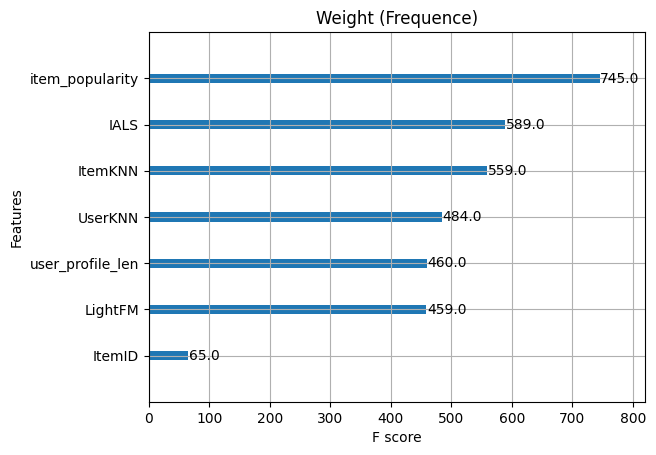

In [110]:
%matplotlib inline
from xgboost import plot_importance

xg_rec.show_importance()

In [111]:
xg_rec.prepare_validation_dataframe(val_dataframe)

Setting-up val_df...


100%|██████████| 12638/12638 [07:36<00:00, 27.68it/s]


Predicting...
Evaluating...


In [112]:
def prepare_submission(ratings: pd.DataFrame, users_to_recommend: np.array, urm_train: sps.csr_matrix, recommender: BaseRecommender, recommendation_length):
    users_ids_and_mappings = ratings[ratings.user_id.isin(users_to_recommend)][["user_id", "mapped_user_id"]].drop_duplicates()
    mapping_to_item_id = dict(zip(ratings.mapped_item_id, ratings.item_id))

    submission = []

    rec_users_arr = users_ids_and_mappings.mapped_user_id.to_numpy()
    recommendations = recommender.recommend(user_id_array= rec_users_arr, cutoff=recommendation_length)

    i = 0

    for idx, row in users_ids_and_mappings.iterrows():
        user_id = row.user_id
        mapped_user_id = row.mapped_user_id

        submission.append((user_id, [mapping_to_item_id[item_id] for item_id in recommendations[i]]))
        i+=1

    return submission

In [113]:
users_to_recommend = target_dataframe.to_numpy().flatten()
users_to_recommend.shape

(10882,)

In [114]:
mapping_to_item_id = dict(zip(ratings.mapped_item_id, ratings.item_id))

In [115]:
urm_ids = np.unique(ratings.user_id)
missing_users = set([i for i in users_to_recommend]) - set([i for i in urm_ids])
missing_users = np.array([x for x in missing_users])

In [116]:
!mkdir /kaggle/working/Results

In [117]:
def write_submission(submissions, name):
    with open(f"/kaggle/working/Results/{name}.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")
        f.close()

In [118]:
submission = prepare_submission(ratings, users_to_recommend, urm_full, xg_rec, recommendation_length=10)

In [119]:
rec_missing = top_pop_final.recommend(missing_users, cutoff=10, remove_seen_flag=False)

In [120]:
for user_id in missing_users:
    submission.append((user_id, [mapping_to_item_id[item_id] for item_id in rec_missing[0]]))

In [121]:
(len(submission), len(users_to_recommend))

(10882, 10882)

In [122]:
write_submission(submission, "xgbrozis")